# 通用代码

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Multiplier = 300

#选择合约 填入想选的合约代码
original_data = pd.read_csv("FFUT_FDT.csv")
cleaned_data = original_data.copy()
cleaned_data = cleaned_data[cleaned_data['Agmtcd'].str.startswith('IF')]  #可选 IH(SSE 50) IF(CSI 300) IC(CSI 500)，but(IM这个不太行，我还没查出问题😭）
cleaned_data = cleaned_data.loc[cleaned_data.groupby('Trddt')['Volume'].idxmax()]

#计算 IH_daily_rr
cleaned_data['IH_daily_rr'] = (cleaned_data['Stprc'] - cleaned_data['Ystprc']) / cleaned_data['Ystprc']
#计算 daily_std
daily_std = cleaned_data['IH_daily_rr'].std()
σ = Ann_std = daily_std * np.sqrt(252)

#这里我是选择了默认个人风险20%，没有计算最小τ，如果需要，可以从策略二里面的代码移过来
τ = 0.2
Capital =10000000
N = (Capital * τ ) / (Multiplier * cleaned_data['Stprc']* σ) 
N = round(N,0)
cleaned_data['N'] = N
cleaned_data['N'] = cleaned_data['N'].shift(1) #基于前一天算出的 N 作为今天买入的合约数量
cleaned_data.iat[0,-1]=1
cleaned_data['returns'] = (cleaned_data['Stprc']- cleaned_data['Ystprc']) * cleaned_data['N'] * Multiplier
cleaned_data.iat[0,-1] = 0
cleaned_data['capital_t'] = cleaned_data['returns'].cumsum() + 10000000
cleaned_data.iat[0,-1] = 10000000
cleaned_data['p_ret'] = cleaned_data['returns']/cleaned_data['capital_t'].shift(1)
#mean_ann_return
daily_avg_return = cleaned_data['p_ret'].mean()
mean_ann_return = daily_avg_return * 252
#Average_drawdowm
Average_drawdowm = ((cleaned_data['Hiprc'] - cleaned_data['Loprc'])/cleaned_data['Hiprc']).mean()
#新的 Ann std
Ann_std = cleaned_data['p_ret'].std() * np.sqrt(252)
#新的 SR  
SR = (mean_ann_return/Ann_std)
#SKEW
skewness = cleaned_data['p_ret'].skew()

# lower&upper tail, lower&upper percentile ratio 2015
# 取20xx年的计算，这里因为书上是按照一年算的，所以这里我取其中一年计算，如果需要计算年平均，可以再改进一下代码。。
df_20xx = cleaned_data.copy()
df_20xx = cleaned_data[cleaned_data['Trddt'].str.startswith('2020')] #可选年份，这里选了2020，与策略二的代码稍有不同
df_20xx["p_ret"] = df_20xx["p_ret"]- daily_avg_return
df_20xx = df_20xx.reset_index()
row_count = len(df_20xx)
data = np.arange(0,row_count,1)
left_value = df_20xx.iloc[int(np.percentile(data, 30)), -1]
right_value = df_20xx.iloc[int(np.percentile(data, 70)), -1]
value1st = df_20xx.iloc[int(np.percentile(data, 1)), -1]
value99st = df_20xx.iloc[int(np.percentile(data, 99)),-1]
lower_pr = value1st / left_value
upper_pr = value99st / right_value
lower_tail = lower_pr/4.43
upper_tail = upper_pr/4.43

df1 = pd.DataFrame({'Strategy: Buy and hold, single contract': ['Years of data', 'Mean annual return','Average drawdown',
                                                               'Annualised standard deviation','Sharpe ratio','Skew','Lower tail'
                                                               ,'Upper tail'], 'Contract Name': ['10', "{:.2%}".format(mean_ann_return) ,
                                                                                                 "{:.2%}".format(-Average_drawdowm),
                                                                                                 "{:.2%}".format(Ann_std)
                                                                                                ,round(SR, 2),round(skewness, 2),
                                                                                                 round(lower_tail,2),round(upper_tail,2)]})
df1.set_index('Strategy: Buy and hold, single contract', inplace=True)
df1

/var/folders/02/tp9zyfnd75v0cdl4kt6z44dc0000gn/T/ipykernel_1496/3151849761.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20xx["p_ret"] = df_20xx["p_ret"]- daily_avg_return


,Contract Name
"Strategy: Buy and hold, single contract",
Years of data,10
Mean annual return,6.14%
Average drawdown,-1.80%
Annualised standard deviation,20.11%
Sharpe ratio,0.31
Skew,0.28
Lower tail,-0.19
Upper tail,0.12


/var/folders/02/tp9zyfnd75v0cdl4kt6z44dc0000gn/T/ipykernel_1496/4222121285.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


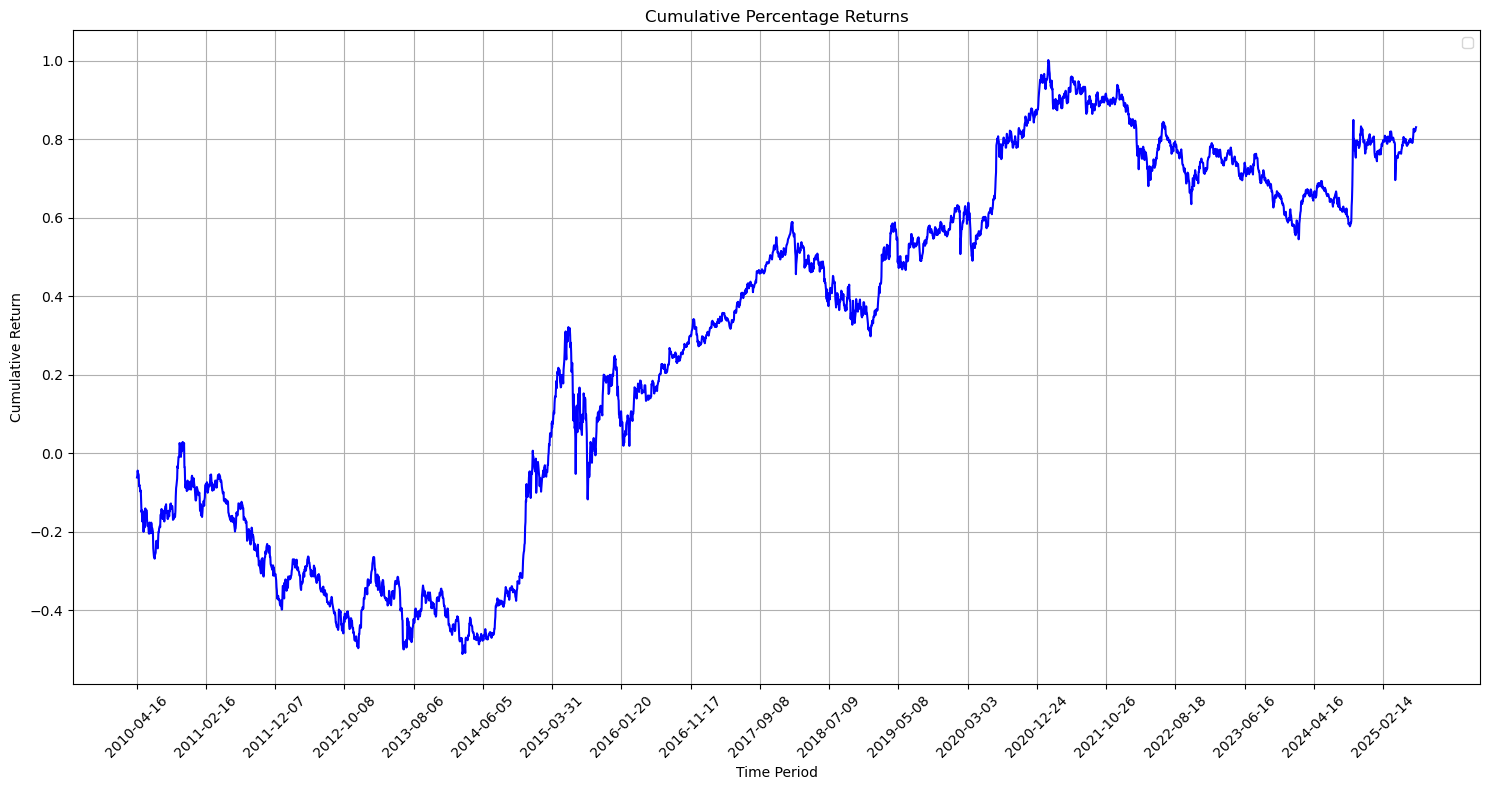

In [6]:
#Account curve (cumulated sum of percentage returns)
df = pd.DataFrame((1 + cleaned_data["p_ret"]).cumprod()-1)
df['Trddt'] = cleaned_data['Trddt']
plt.figure(figsize=(15, 8))
plt.plot(df['Trddt'], df['p_ret'],'b-')
plt.title("Cumulative Percentage Returns")
plt.ylabel("Cumulative Return")
plt.xlabel("Time Period")
plt.xticks(df['Trddt'][::200], rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

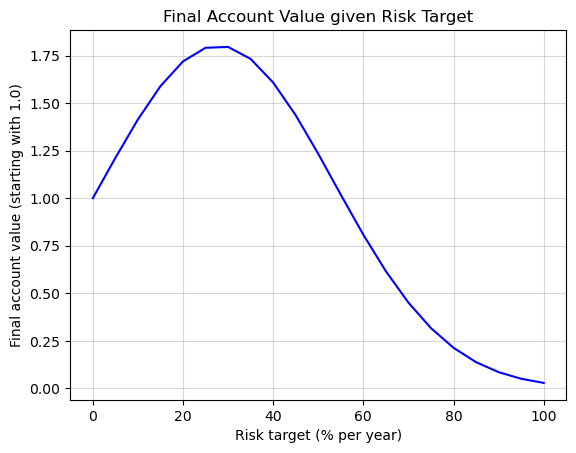

In [7]:
daily_returns = cleaned_data['returns'].dropna()
sigma = daily_returns.std() * np.sqrt(245)
risk_targets = np.arange(0, 101, 5) 

final_values = []
for target in risk_targets:
    scale_factor = target / (sigma * 100) 
    scaled_returns = daily_returns * scale_factor
    capital = 1.0
    for ret in scaled_returns:
        capital *= (1 + ret)
    final_values.append(capital)
plt.plot(risk_targets, final_values,'b-')
plt.xlabel('Risk target (% per year)')
plt.ylabel('Final account value (starting with 1.0)')
plt.title('Final Account Value given Risk Target')
plt.grid(True, alpha=0.5) 
plt.show()